In [7]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training Setup

In [8]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cuda", 0)
train_size=0.00108

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1D(reduction="sum", std=1e-4, store_filters=True, alpha=0.02)
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse  

Cuda installed! Running on GPU 0 GeForce GTX 1650!


In [3]:
# Training loop
def train_model(model, optimizer, train_loader, nepochs=150, switch_at_epoch=0, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            if epoch < switch_at_epoch:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, l2loss, device=device)
            else:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, awi1D, device=device)
            epoch_mse = validate(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
                

            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)
                if isinstance(recon, tuple): recon = recon[0] # in case model returns more than one output, recon must be the first
                
                f = awi1D(recon, X)
                v, T = awi1D.v_all[0], awi1D.T_arr

                print("\n", log)
                print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())

                plot_grad_flow(model.named_parameters())

                fig, axs = plt.subplots(2,3)
                axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0., vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0., vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")

                axs[1, 0].plot(v.detach().cpu().numpy())
                axs[1, 0].plot(T.flatten().detach().cpu().numpy(), "--")
                axs[1, 0].set_title("T-1D vs v-1D")
                axs[1, 0].set_ylim(None, 1.1)

                axs[1, 1].plot((T.flatten() - v).detach().cpu().numpy())
                axs[1, 1].set_title("T1D - v1D")
                axs[1, 1].set_ylim(None, 1.1)
                plt.show()

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="aw_loss1d")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# MNIST Example

## Datasets and Dataloaders

In [15]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])

ds = MNIST("./", download=True, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())


Trainable Images: 64
torch.Size([1, 1, 28, 28]) 0.0 0.9960784316062927


## Autoencoder FC

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.23087912797927856, 'train_awi1d_loss': 22.570903778076172, 'train_kl_loss': 0.0}
 argidx T, v:  783 626


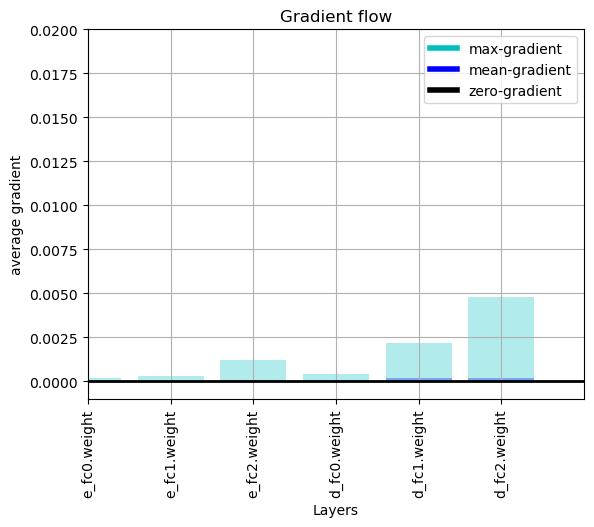

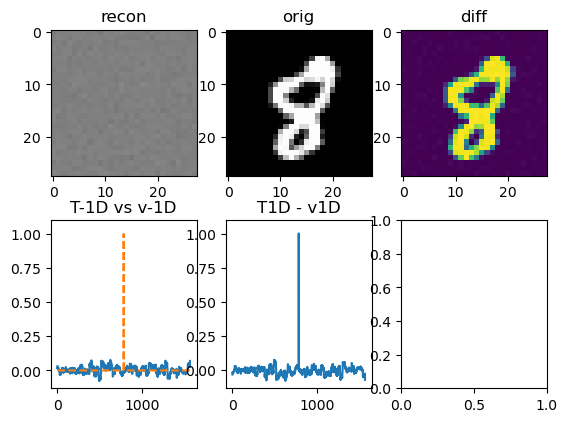

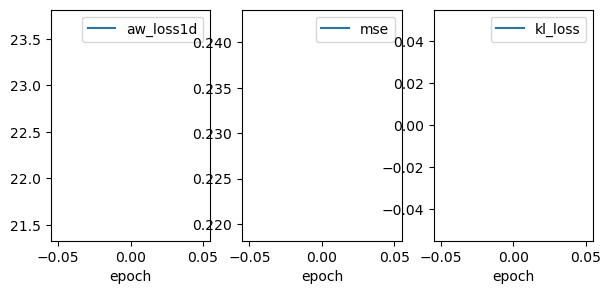

 20% (20 of 100) |####                   | Elapsed Time: 0:00:58 ETA:   0:03:48


 {'epoch': 20, 'train_mse': 0.19664844870567322, 'train_awi1d_loss': 18.93218231201172, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


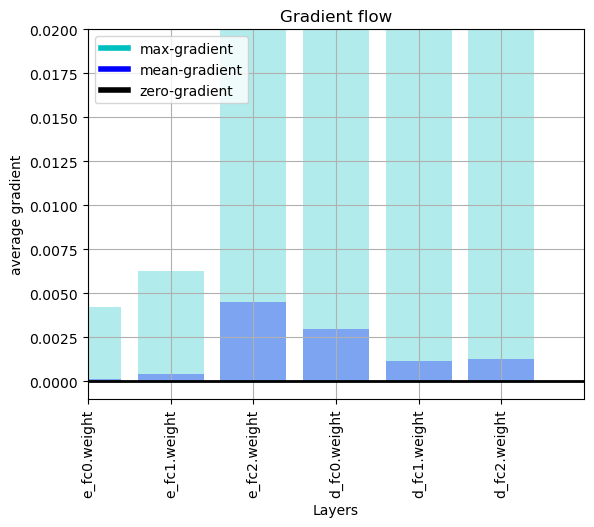

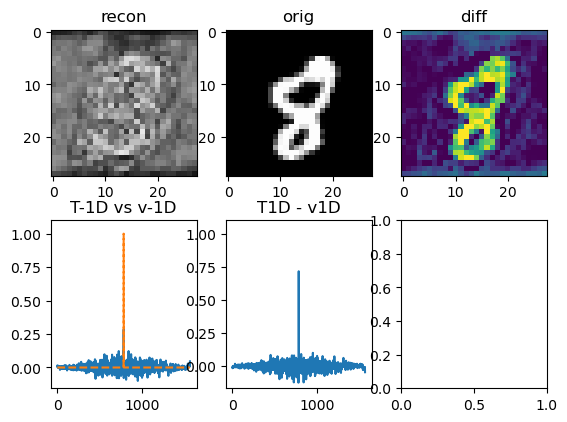

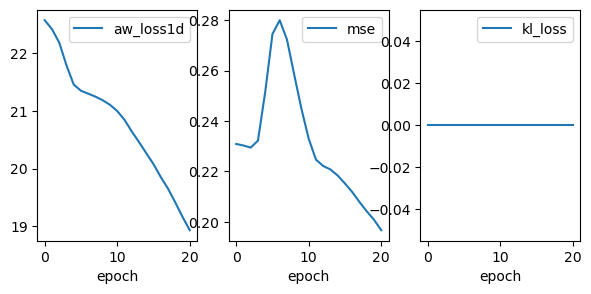

 40% (40 of 100) |#########              | Elapsed Time: 0:01:56 ETA:   0:02:52


 {'epoch': 40, 'train_mse': 0.10930204391479492, 'train_awi1d_loss': 13.180074691772461, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


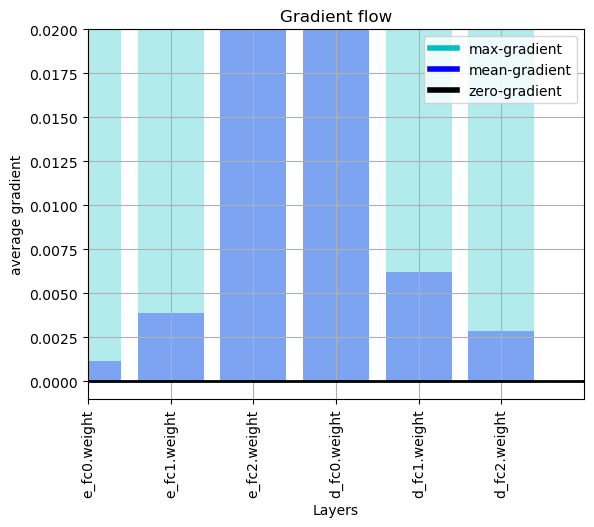

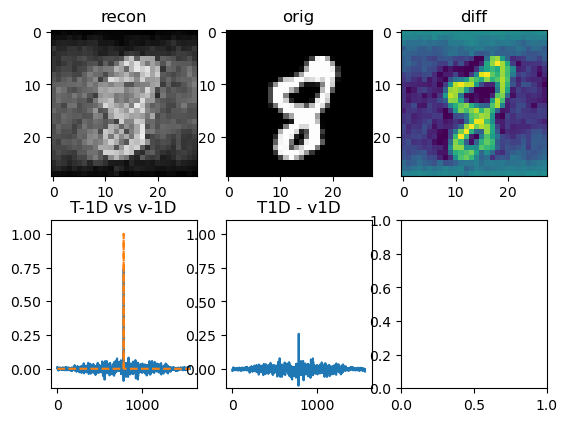

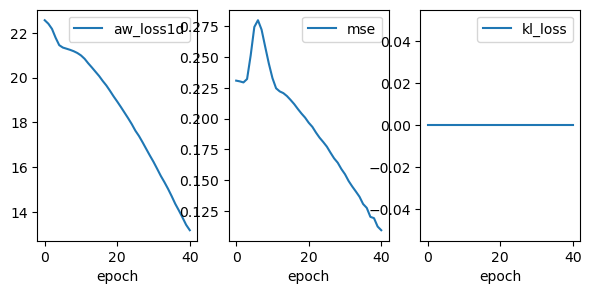

 60% (60 of 100) |#############          | Elapsed Time: 0:02:55 ETA:   0:01:55


 {'epoch': 60, 'train_mse': 0.05103607848286629, 'train_awi1d_loss': 8.00964069366455, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


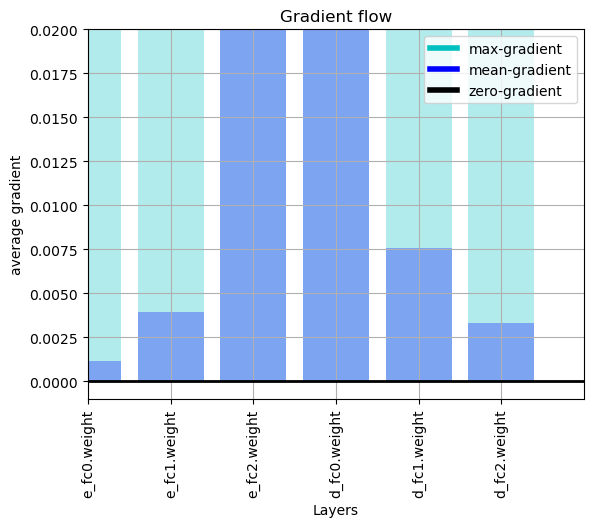

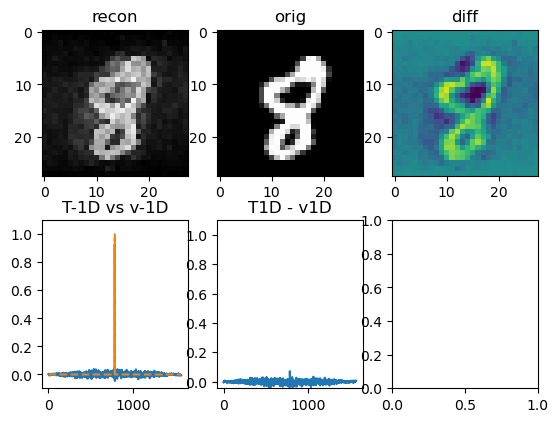

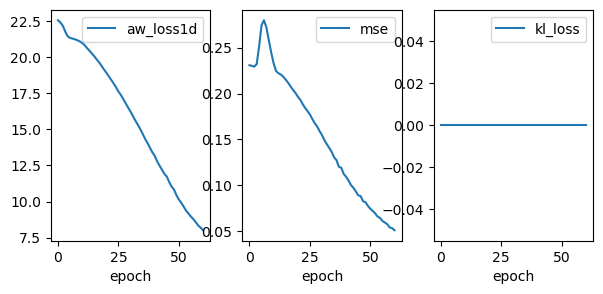

 80% (80 of 100) |##################     | Elapsed Time: 0:03:54 ETA:   0:00:57


 {'epoch': 80, 'train_mse': 0.026051390916109085, 'train_awi1d_loss': 5.640896797180176, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


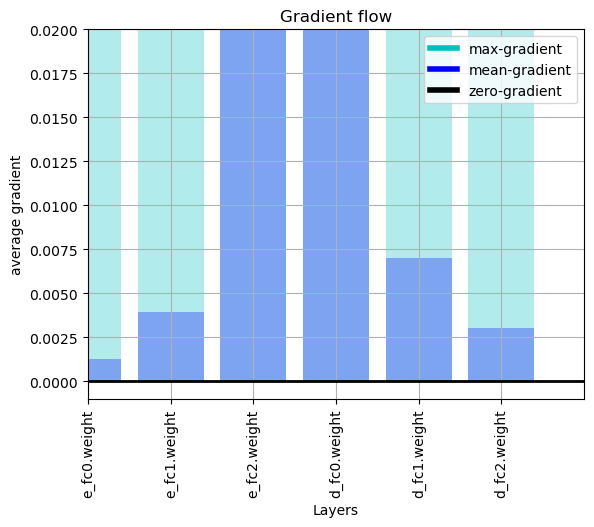

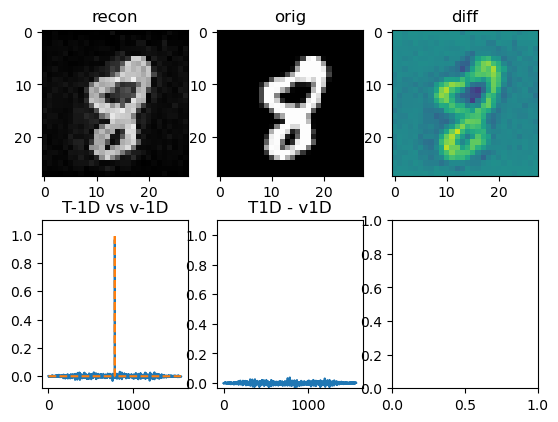

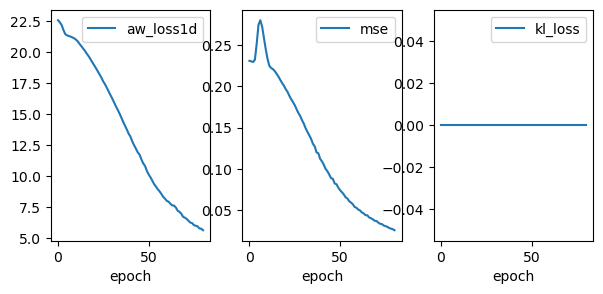

 99% (99 of 100) |###################### | Elapsed Time: 0:04:49 ETA:   0:00:02


 {'epoch': 99, 'train_mse': 0.014200106263160706, 'train_awi1d_loss': 4.582454681396484, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


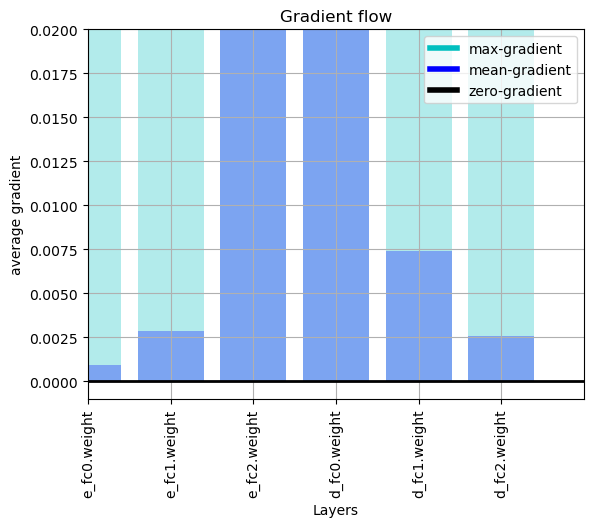

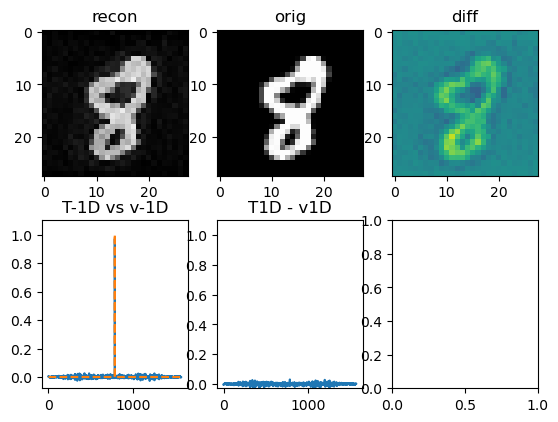

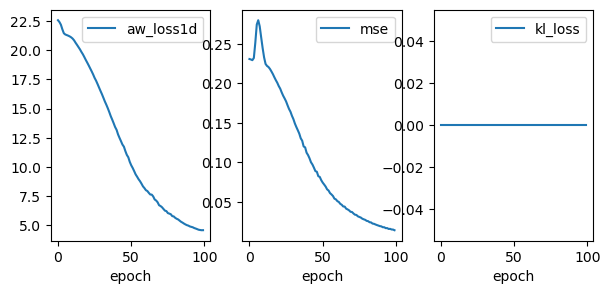

100% (100 of 100) |######################| Elapsed Time: 0:04:50 Time:  0:04:50


In [16]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Visualise Loss Landscape of Autoencoder (FC)

Train Subset len:  16
Angle between x_dir and y_dir: 90.01 °


100% (625 of 625) |######################| Elapsed Time: 0:07:29 Time:  0:07:29


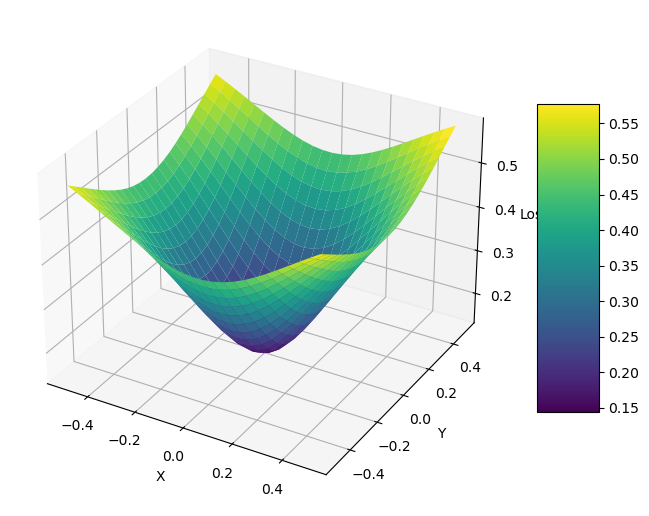

In [10]:
train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Train Subset len: ", len(train_subset))
xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)


## Variational Autoencoder (FC)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.23145495355129242, 'train_awi1d_loss': 22.589139938354492, 'train_kl_loss': 517.947509765625}
 argidx T, v:  783 626


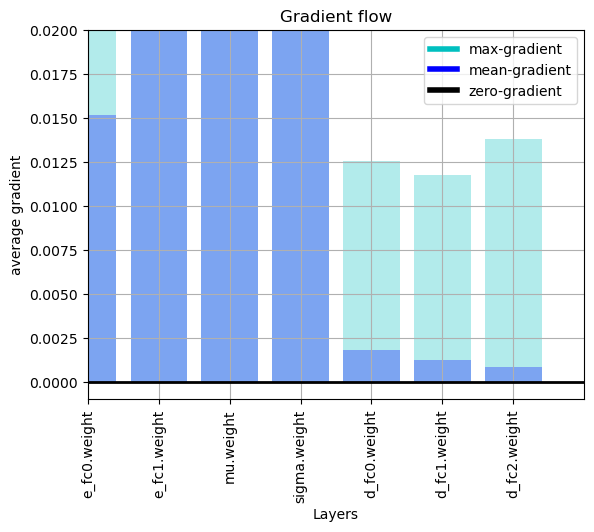

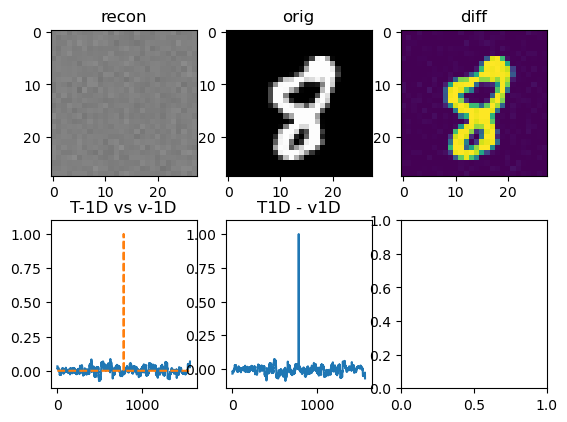

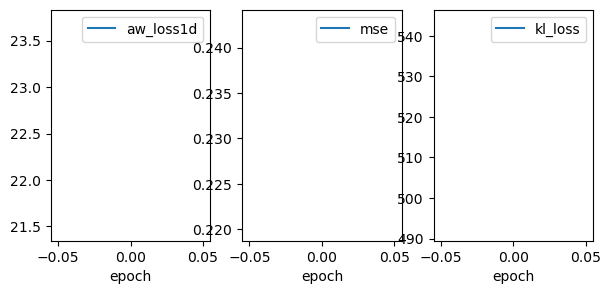

 20% (20 of 100) |####                   | Elapsed Time: 0:00:59 ETA:   0:03:54


 {'epoch': 20, 'train_mse': 0.2274239957332611, 'train_awi1d_loss': 21.166000366210938, 'train_kl_loss': 512.03857421875}
 argidx T, v:  783 783


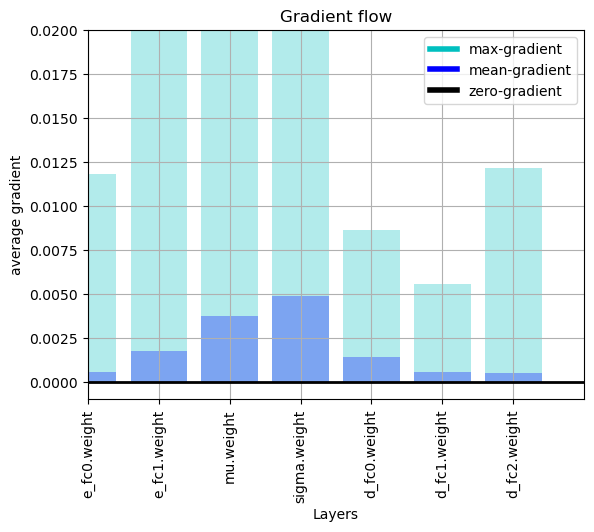

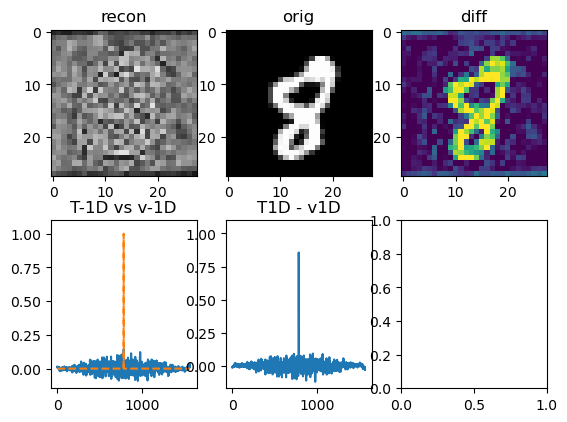

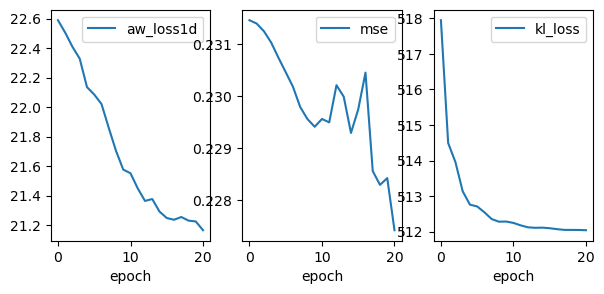

 40% (40 of 100) |#########              | Elapsed Time: 0:01:58 ETA:   0:02:56


 {'epoch': 40, 'train_mse': 0.19727842509746552, 'train_awi1d_loss': 21.046852111816406, 'train_kl_loss': 512.0032958984375}
 argidx T, v:  783 783


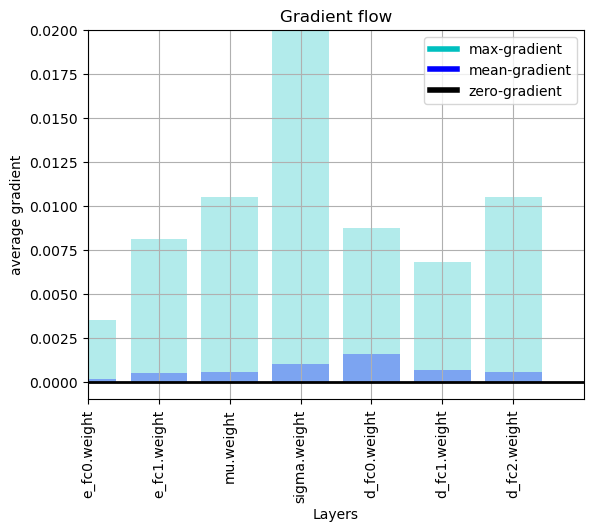

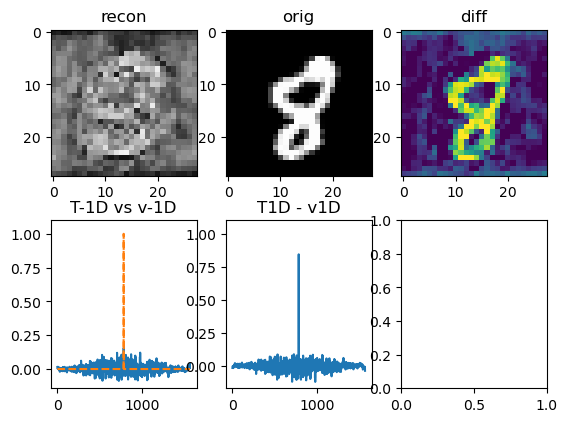

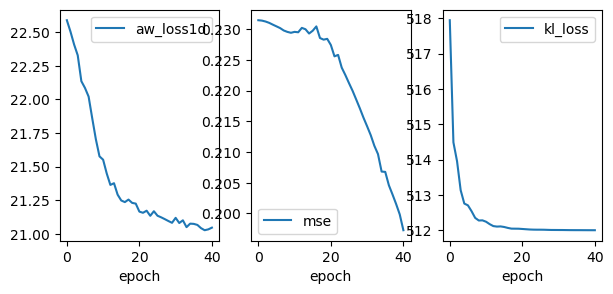

 60% (60 of 100) |#############          | Elapsed Time: 0:02:57 ETA:   0:01:56


 {'epoch': 60, 'train_mse': 0.16379418969154358, 'train_awi1d_loss': 20.90401840209961, 'train_kl_loss': 512.0014038085938}
 argidx T, v:  783 783


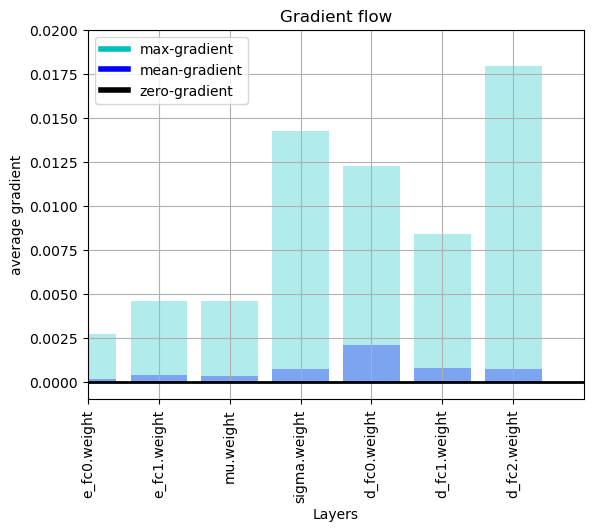

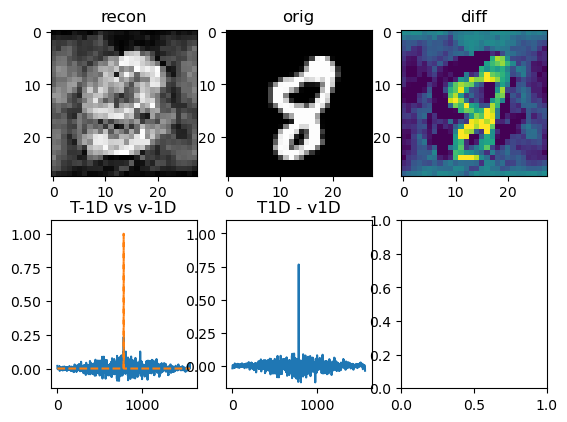

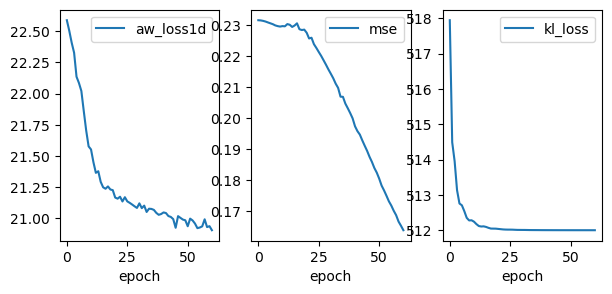

 80% (80 of 100) |##################     | Elapsed Time: 0:03:57 ETA:   0:00:59


 {'epoch': 80, 'train_mse': 0.1393485814332962, 'train_awi1d_loss': 20.822261810302734, 'train_kl_loss': 512.00146484375}
 argidx T, v:  783 783


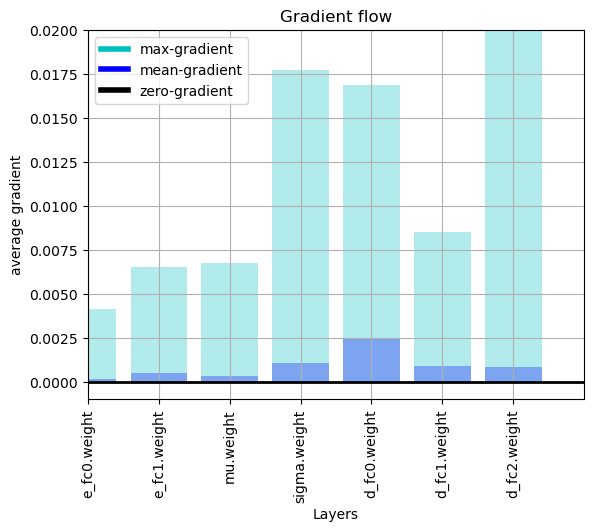

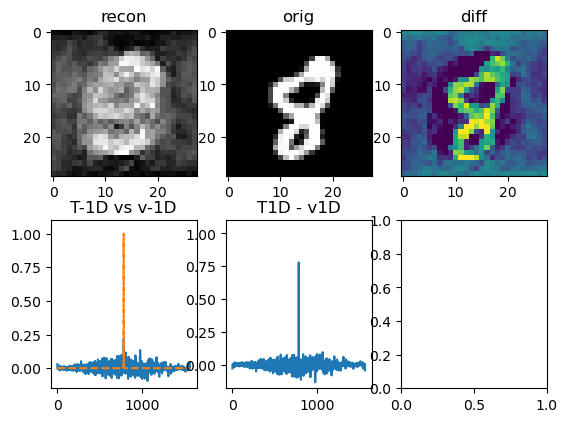

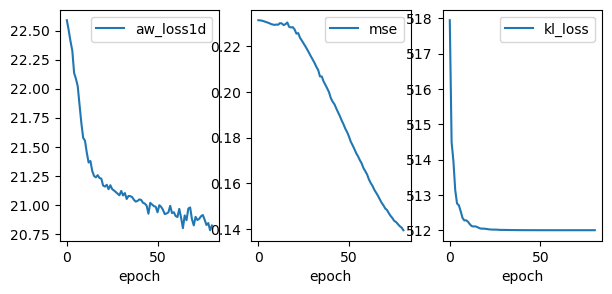

 99% (99 of 100) |###################### | Elapsed Time: 0:04:54 ETA:   0:00:02


 {'epoch': 99, 'train_mse': 0.13232766091823578, 'train_awi1d_loss': 20.788318634033203, 'train_kl_loss': 512.001953125}
 argidx T, v:  783 783


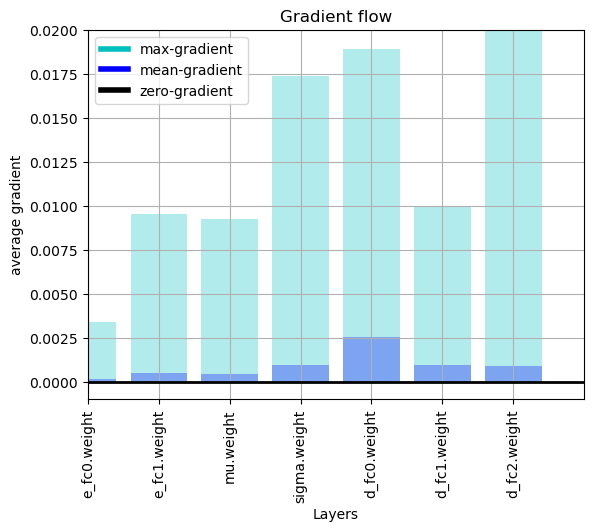

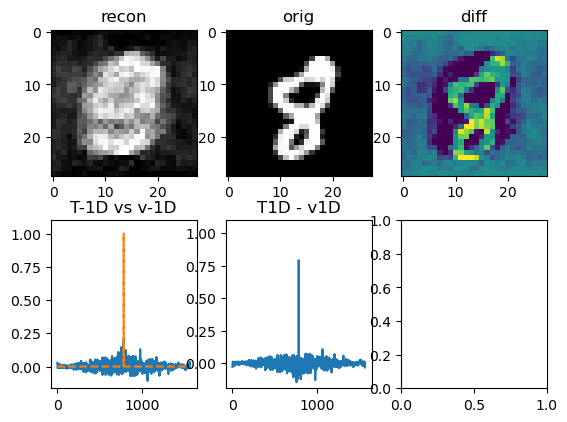

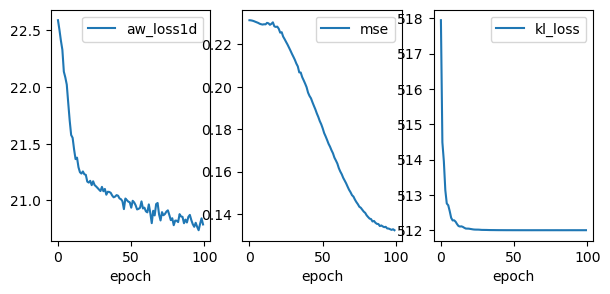

100% (100 of 100) |######################| Elapsed Time: 0:04:55 Time:  0:04:55


In [11]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
 
# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.26504427194595337, 'train_awi1d_loss': 22.57396697998047, 'train_kl_loss': 0.0}
 argidx T, v:  783 626


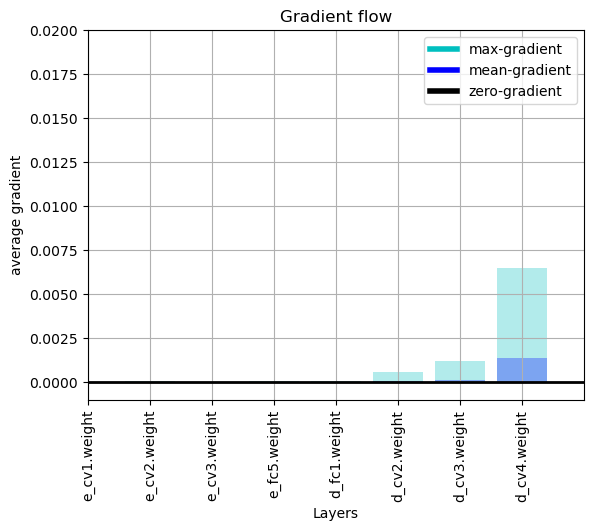

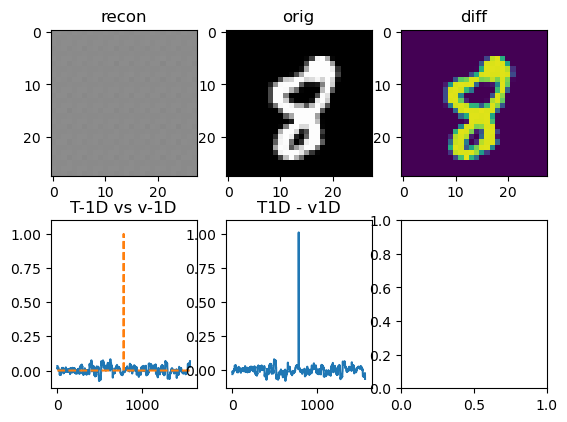

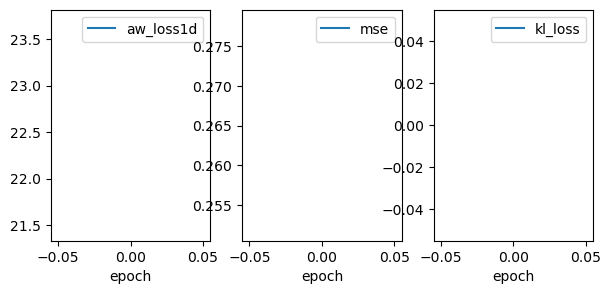

 20% (20 of 100) |####                   | Elapsed Time: 0:00:58 ETA:   0:03:51


 {'epoch': 20, 'train_mse': 0.2649558484554291, 'train_awi1d_loss': 21.234195709228516, 'train_kl_loss': 0.0}
 argidx T, v:  783 978


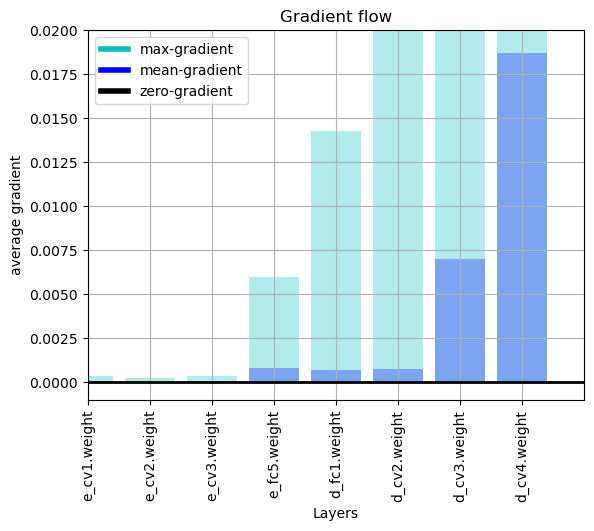

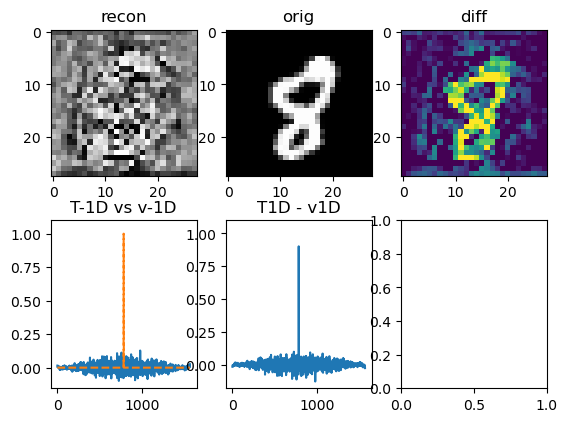

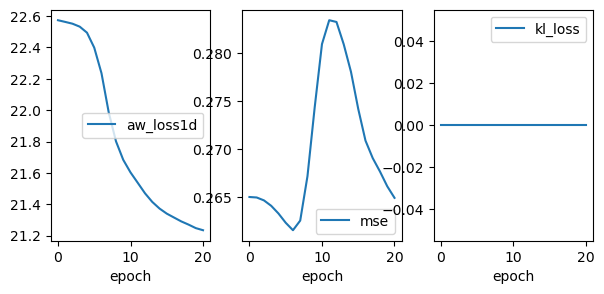

 40% (40 of 100) |#########              | Elapsed Time: 0:01:57 ETA:   0:02:53


 {'epoch': 40, 'train_mse': 0.21971961855888367, 'train_awi1d_loss': 20.53335952758789, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


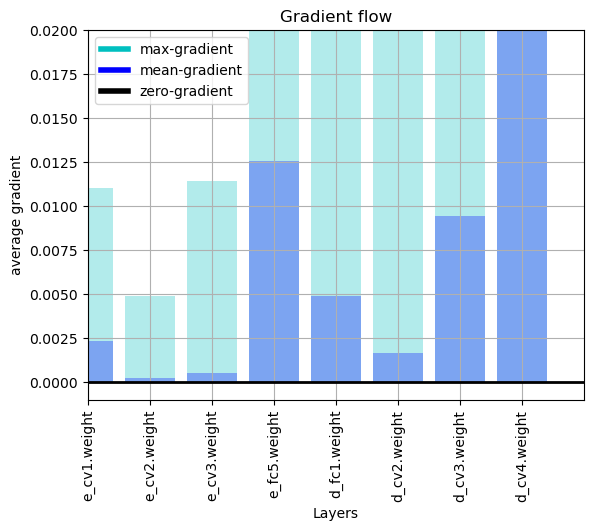

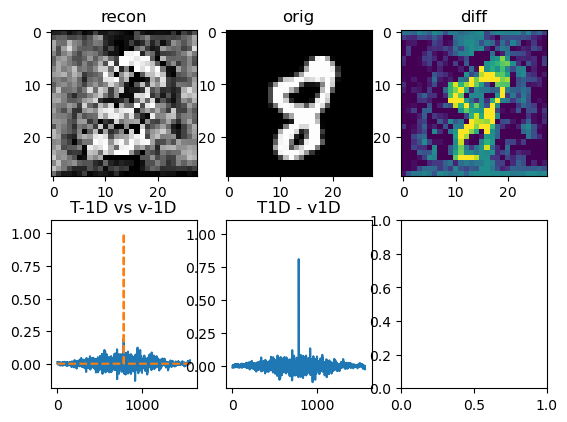

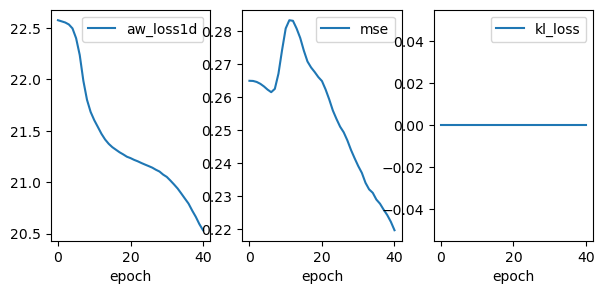

 60% (60 of 100) |#############          | Elapsed Time: 0:02:55 ETA:   0:01:55


 {'epoch': 60, 'train_mse': 0.17401501536369324, 'train_awi1d_loss': 18.52474594116211, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


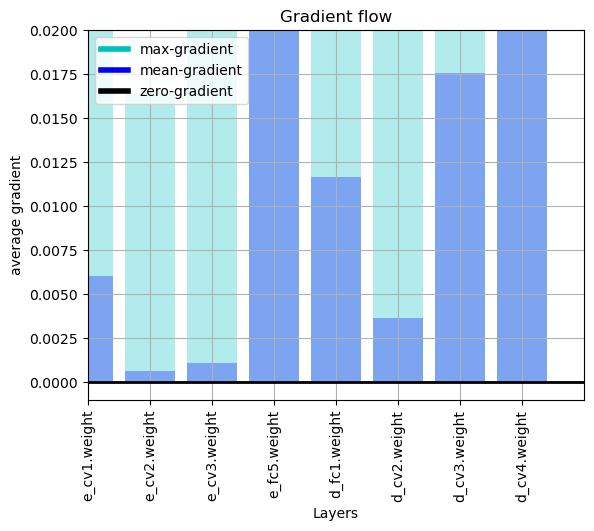

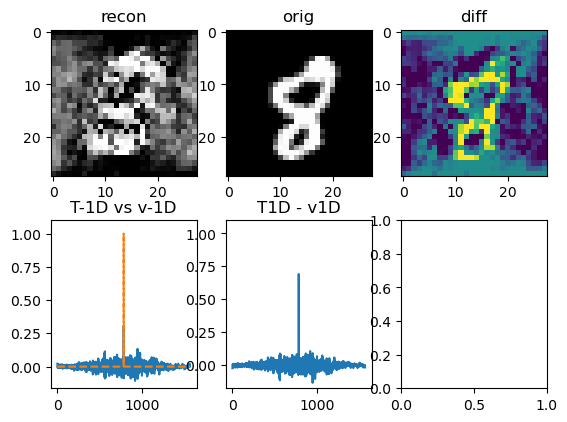

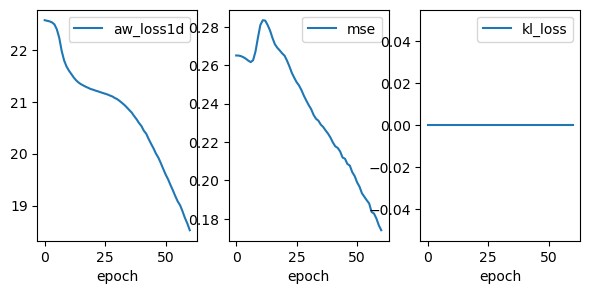

 80% (80 of 100) |##################     | Elapsed Time: 0:03:55 ETA:   0:00:59


 {'epoch': 80, 'train_mse': 0.12443247437477112, 'train_awi1d_loss': 16.579978942871094, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


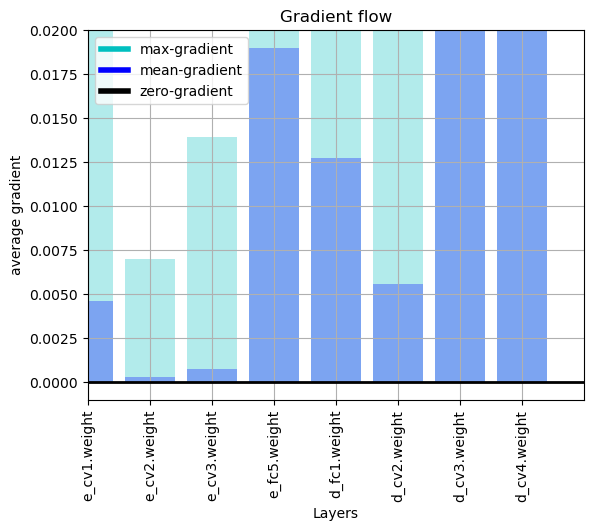

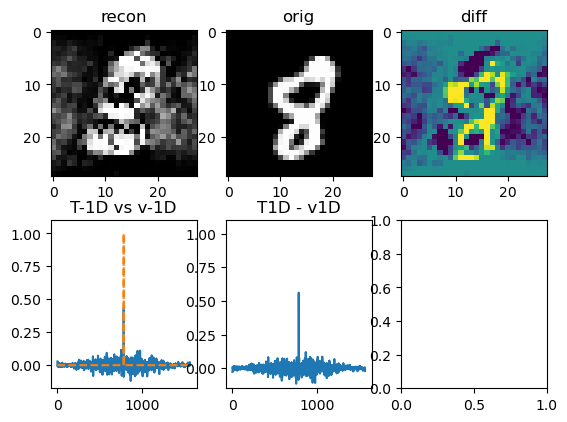

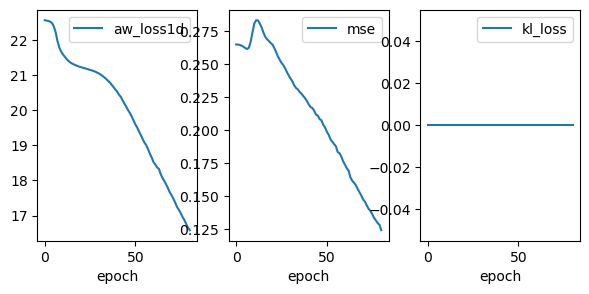

 99% (99 of 100) |###################### | Elapsed Time: 0:04:52 ETA:   0:00:03


 {'epoch': 99, 'train_mse': 0.10168445855379105, 'train_awi1d_loss': 15.240294456481934, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


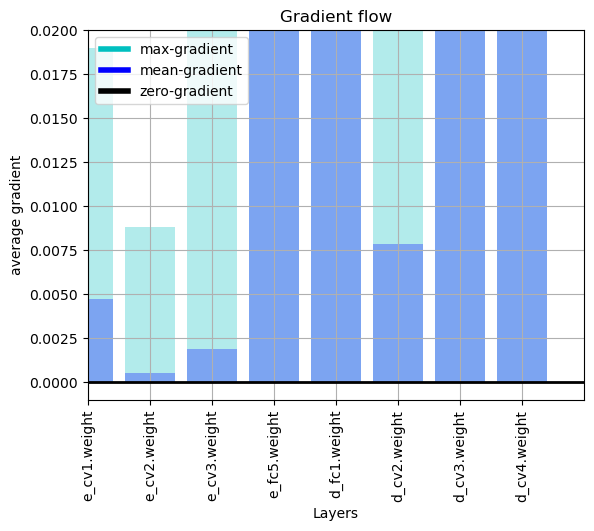

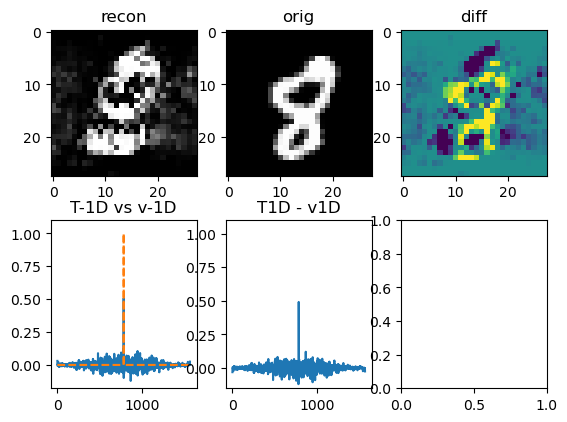

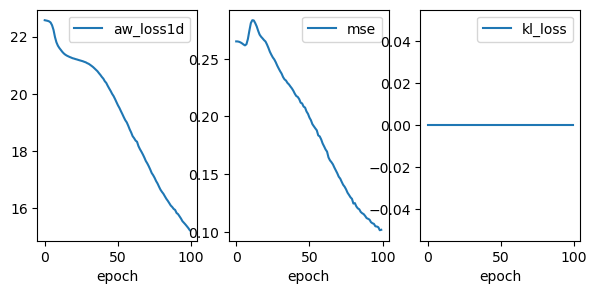

100% (100 of 100) |######################| Elapsed Time: 0:04:53 Time:  0:04:53


In [22]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Variational Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.23051676154136658, 'train_awi1d_loss': 22.583240509033203, 'train_kl_loss': 517.708984375}
 argidx T, v:  783 626


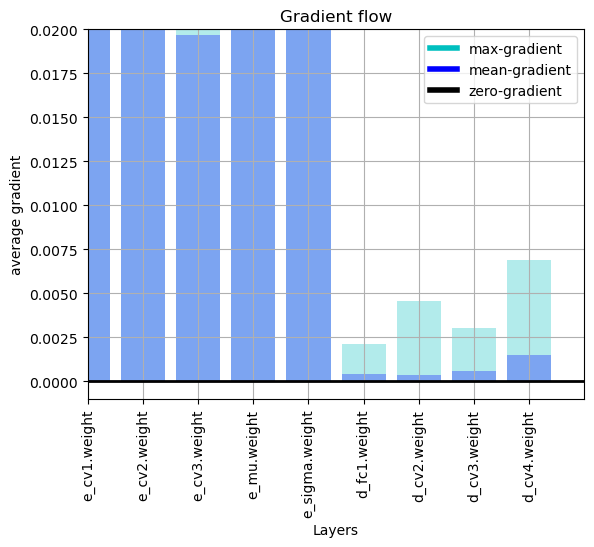

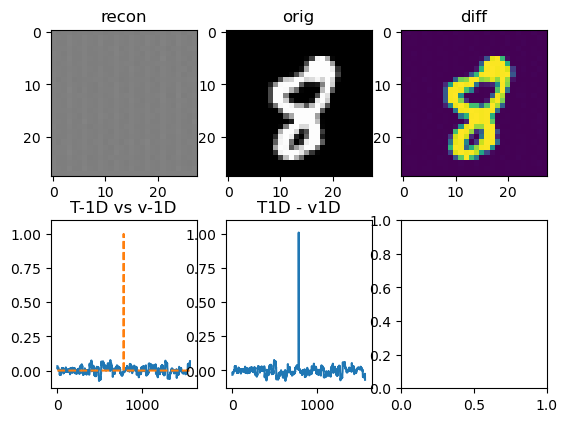

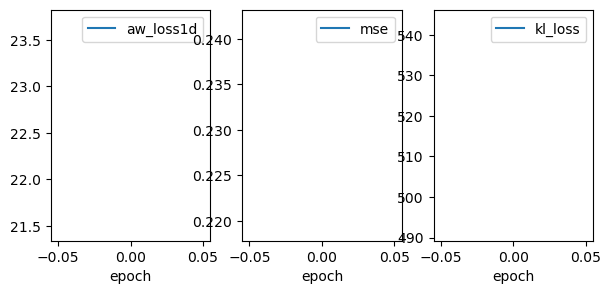

 20% (20 of 100) |####                   | Elapsed Time: 0:00:59 ETA:   0:03:56


 {'epoch': 20, 'train_mse': 0.2209753394126892, 'train_awi1d_loss': 22.082481384277344, 'train_kl_loss': 512.017333984375}
 argidx T, v:  783 528


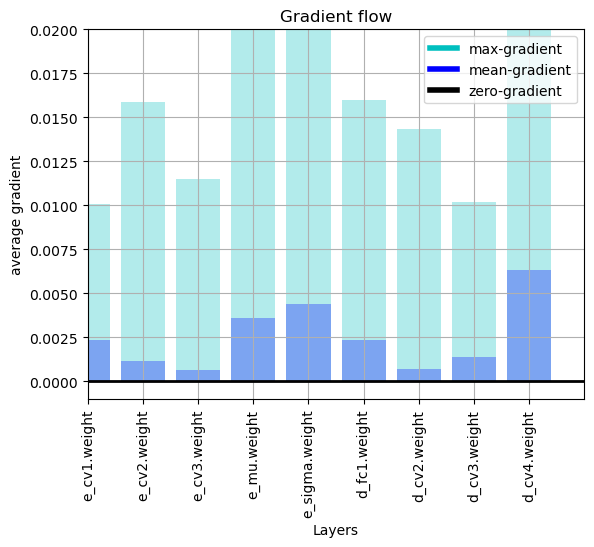

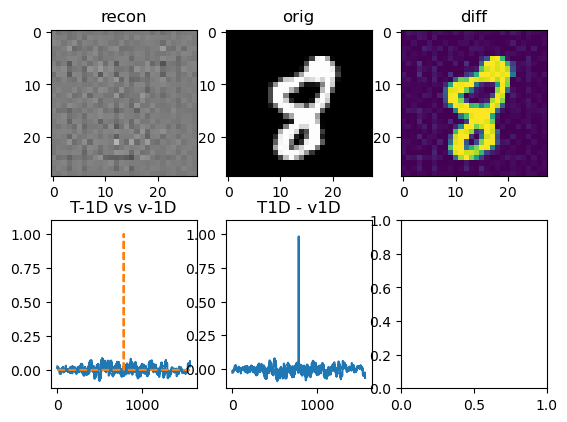

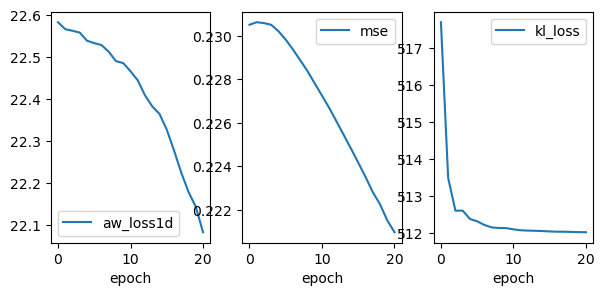

 40% (40 of 100) |#########              | Elapsed Time: 0:01:59 ETA:   0:02:52


 {'epoch': 40, 'train_mse': 0.2162109911441803, 'train_awi1d_loss': 21.386260986328125, 'train_kl_loss': 512.004150390625}
 argidx T, v:  783 950


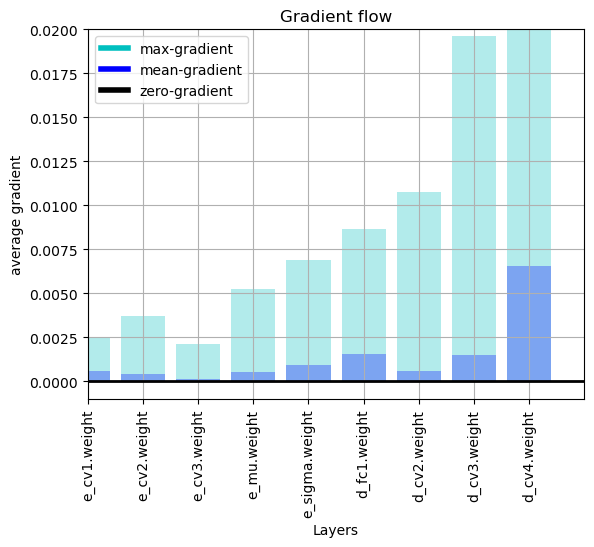

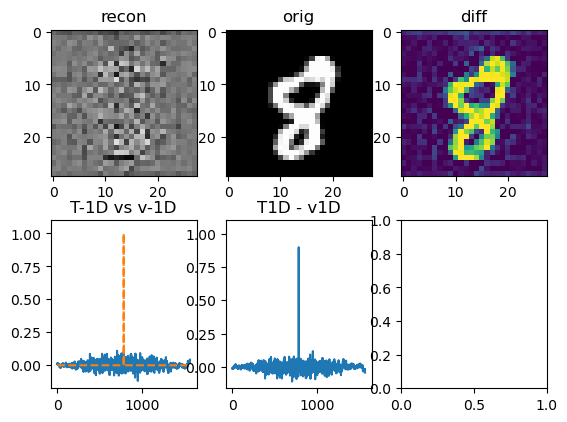

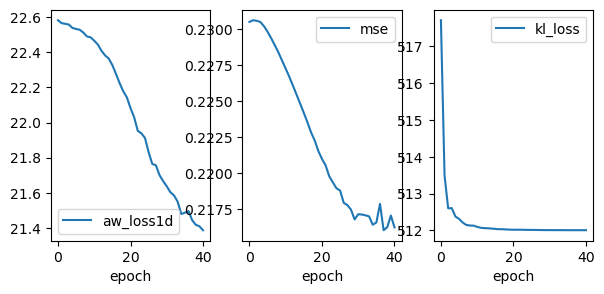

 60% (60 of 100) |#############          | Elapsed Time: 0:02:58 ETA:   0:01:56


 {'epoch': 60, 'train_mse': 0.2127932906150818, 'train_awi1d_loss': 21.164825439453125, 'train_kl_loss': 512.0020751953125}
 argidx T, v:  783 783


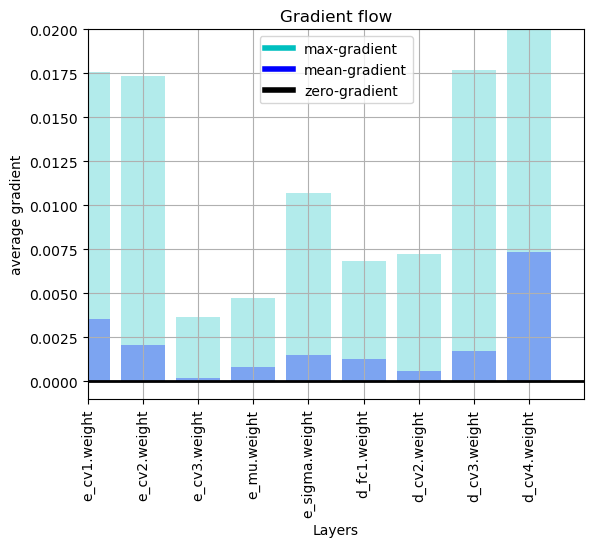

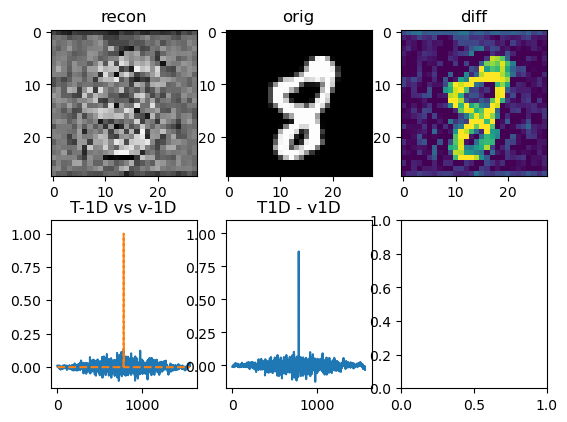

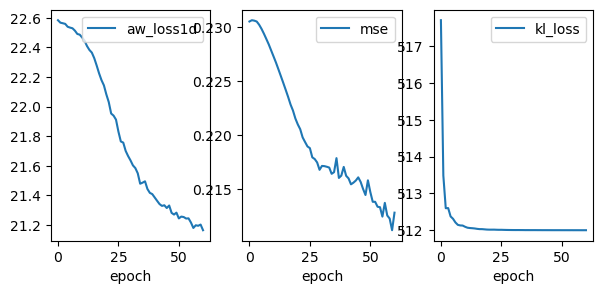

 80% (80 of 100) |##################     | Elapsed Time: 0:03:57 ETA:   0:00:57


 {'epoch': 80, 'train_mse': 0.19917955994606018, 'train_awi1d_loss': 21.057212829589844, 'train_kl_loss': 512.001220703125}
 argidx T, v:  783 783


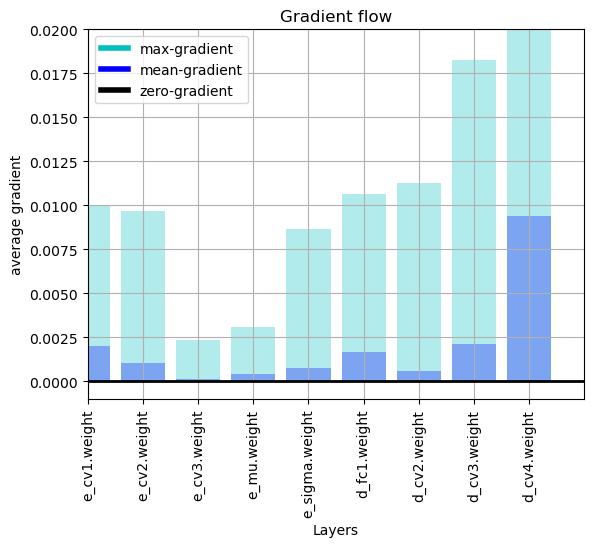

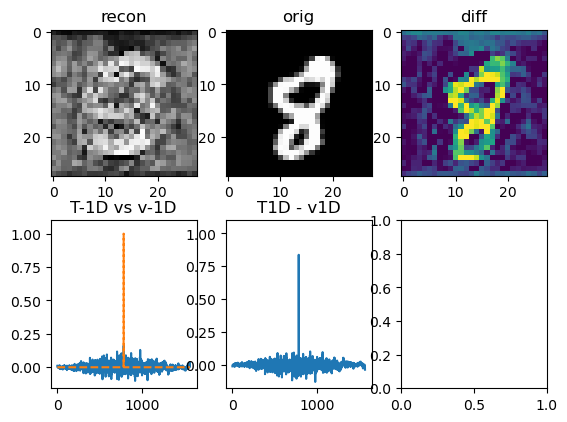

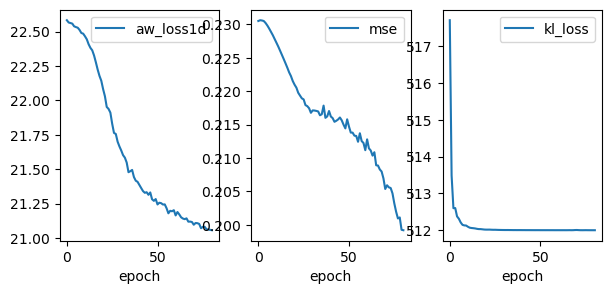

 99% (99 of 100) |###################### | Elapsed Time: 0:04:53 ETA:   0:00:02


 {'epoch': 99, 'train_mse': 0.1809442788362503, 'train_awi1d_loss': 20.9285888671875, 'train_kl_loss': 512.0028686523438}
 argidx T, v:  783 783


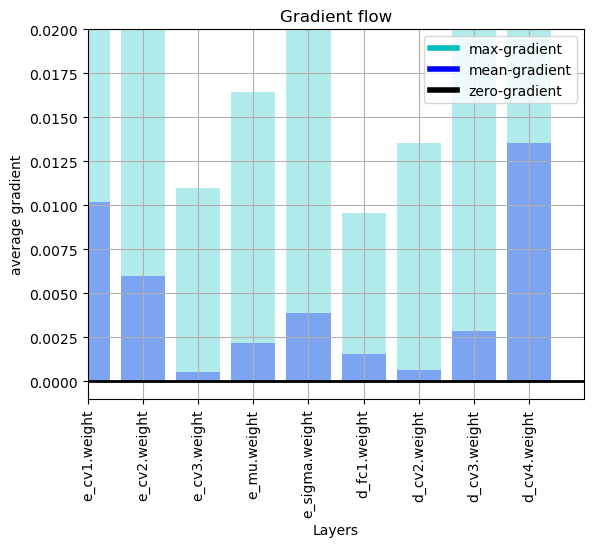

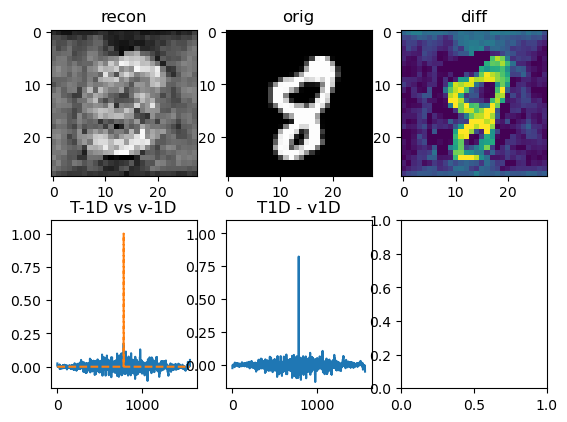

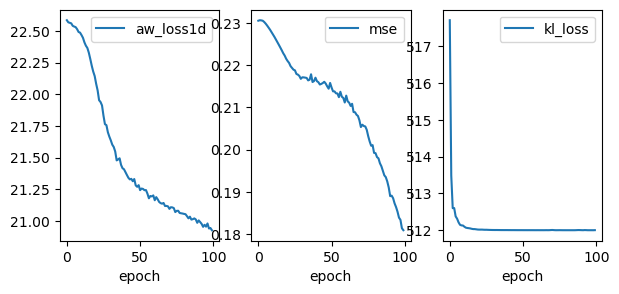

100% (100 of 100) |######################| Elapsed Time: 0:04:54 Time:  0:04:54


In [23]:
model = CVAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)